<a href="https://colab.research.google.com/github/espartaca75-prog/Optmizacion_dinamica_discreta/blob/main/04_COD_programaci%C3%B3n_din%C3%A1mica_Ejemplo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejemplo 4

---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import pandas as pd

In [2]:
# --- 1. CONFIGURACIÓN DEL PROBLEMA ---
T = 10           # Horizonte temporal
x0 = 100.0       # Stock inicial
alpha = 1.25     # Crecimiento biológico
gamma = 0.5      # Sensibilidad (parámetro gamma)

# Diccionarios para almacenar los resultados del "descubrimiento"
valor_funciones = {}
politicas_h = {} # Almacenaremos el coeficiente h_t tal que c_t = h_t * x_t

In [3]:
# --- 2. FASE DE DESCUBRIMIENTO: INDUCCIÓN HACIA ATRÁS ---
# Paso 1: Condición terminal en T+1
valor_funciones[T + 1] = lambda x: -np.exp(-gamma * x)

print("Iniciando Fase de Descubrimiento...")

for t in range(T, -1, -1):
    # Definimos la función objetivo para esta etapa
    def objetivo_negativo(c, x_actual, t_idx):
        recompensa_inmediata = -np.exp(-gamma * c)
        x_siguiente = alpha * x_actual - c
        if x_siguiente < 0: return 1e10 # Penalización por stock negativo

        valor_futuro = valor_funciones[t_idx + 1](x_siguiente)
        return -(recompensa_inmediata + valor_futuro)

    # DESCUBRIMIENTO NUMÉRICO: Probamos con un x genérico para hallar la proporción h_t
    x_test = 100.0
    res = minimize_scalar(objetivo_negativo, args=(x_test, t),
                          bounds=(0, alpha * x_test), method='bounded')

    # Guardamos la proporción óptima descubierta (h_t = c* / x)
    h_t = res.x / x_test
    politicas_h[t] = h_t

    # Actualizamos la función de valor para la etapa anterior usando el coeficiente hallado
    valor_funciones[t] = lambda x_val, h=h_t, t_idx=t: -objetivo_negativo(h * x_val, x_val, t_idx)

    print(f"Etapa t={t}: Coeficiente de extracción descubierto h={h_t:.4f}")


Iniciando Fase de Descubrimiento...
Etapa t=10: Coeficiente de extracción descubierto h=0.6250
Etapa t=9: Coeficiente de extracción descubierto h=0.4780
Etapa t=8: Coeficiente de extracción descubierto h=0.4010
Etapa t=7: Coeficiente de extracción descubierto h=0.3542
Etapa t=6: Coeficiente de extracción descubierto h=0.3233
Etapa t=5: Coeficiente de extracción descubierto h=0.3017
Etapa t=4: Coeficiente de extracción descubierto h=0.2860
Etapa t=3: Coeficiente de extracción descubierto h=0.2743
Etapa t=2: Coeficiente de extracción descubierto h=0.2654
Etapa t=1: Coeficiente de extracción descubierto h=0.2586
Etapa t=0: Coeficiente de extracción descubierto h=0.2532


In [4]:
# --- 3. FASE DE EJECUCIÓN: TRAYECTORIA ÓPTIMA ---
# Una vez tenemos los coeficientes, reconstruimos la ruta hacia adelante
x_hist = [x0]
c_hist = []

for t in range(T + 1):
    x_t = x_hist[-1]
    # Aplicamos la regla de política: c_t = h_t * x_t
    c_t = politicas_h[t] * x_t
    c_hist.append(c_t)

    if t < T:
        x_next = alpha * x_t - c_t
        x_hist.append(x_next)

# --- CÁLCULO DEL ESTADO FINAL ---
# En el último periodo se debe cumplir la condición terminal
x_final = alpha * x_hist[-1] - c_hist[-1]

# Creamos la lista completa que incluye el stock desde t=0 hasta t=T+1
x_hist_completo = x_hist + [x_final]

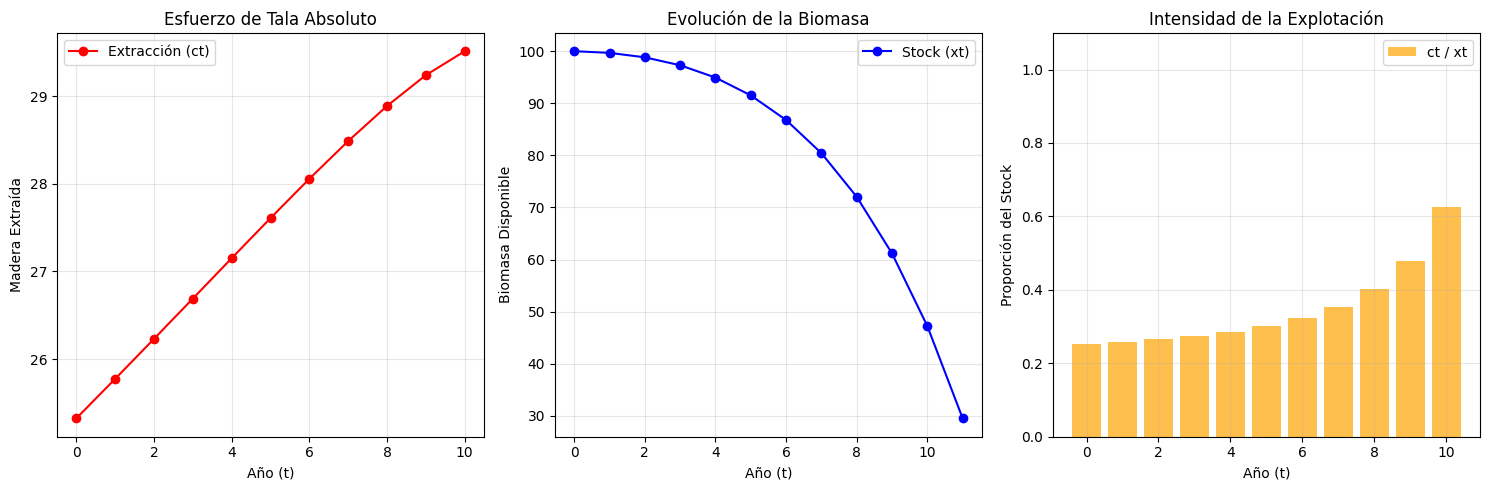

In [5]:
# ---- 4.VISUALIZACIÓN DE RESULTADOS ----
plt.figure(figsize=(15, 5))

# Gráfico 1: Trayectoria de Extracción (t=0 hasta T)
plt.subplot(1, 3, 1)
plt.plot(range(T + 1), c_hist, 'ro-', label='Extracción (ct)')
plt.title('Esfuerzo de Tala Absoluto')
plt.xlabel('Año (t)'); plt.ylabel('Madera Extraída')
plt.grid(True, alpha=0.3); plt.legend()

# Gráfico 2: Evolución del Stock (t=0 hasta T+1)
plt.subplot(1, 3, 2)
# Usamos x_hist_completo que ahora tiene T+2 elementos
plt.plot(range(T + 2), x_hist_completo, 'bo-', label='Stock (xt)')
plt.title('Evolución de la Biomasa')
plt.xlabel('Año (t)'); plt.ylabel('Biomasa Disponible')
plt.grid(True, alpha=0.3); plt.legend()

# Gráfico 3: Tasa de Extracción Relativa (ct / xt)
tasa_extraccion = [c / x for c, x in zip(c_hist, x_hist)]
plt.subplot(1, 3, 3)
plt.bar(range(T + 1), tasa_extraccion, color='orange', alpha=0.7, label='ct / xt')
plt.title('Intensidad de la Explotación')
plt.xlabel('Año (t)'); plt.ylabel('Proporción del Stock')
plt.ylim(0, 1.1); plt.grid(True, alpha=0.3); plt.legend()

plt.tight_layout()
plt.show()

In [6]:
# --- 5. ARMADO DE TABLA FINAL ---
# Calculamos x_{T+1} usando la última extracción y la dinámica biológica
x_final = alpha * x_hist[-1] - c_hist[-1]
# La trayectoria de estado tiene T+2 elementos (desde 0 hasta T+1)
x_trayectoria_completa = x_hist + [x_final]
# La trayectoria de control tiene T+1 elementos, agregamos 'N/A' para el periodo T+1
c_trayectoria_completa = list(c_hist) + [np.nan]

# Generamos el dataframe
df_final = pd.DataFrame({
    'Periodo (t)': range(T + 2),
    'Stock (xt)': x_trayectoria_completa,
    'Extracción (ct*)': c_trayectoria_completa
})

print("\nTABLA DE TRAYECTORIA ÓPTIMA FORESTAL:")
print(df_final.to_string(index=False, na_rep='(Legado)'))

# verificamos la condición terminal
print(f"\nVerificación de equilibrio terminal:")
print(f"Extracción en T={T}: {c_hist[-1]:.4f}")
print(f"Stock remanente en T+1: {x_final:.4f}")


TABLA DE TRAYECTORIA ÓPTIMA FORESTAL:
 Periodo (t)  Stock (xt)  Extracción (ct*)
           0  100.000000         25.323171
           1   99.676829         25.774004
           2   98.822033         26.230161
           3   97.297380         26.689894
           4   94.931830         27.150512
           5   91.514276         27.607980
           6   86.784864         28.056379
           7   80.424701         28.487091
           8   72.043786         28.887596
           9   61.167136         29.239290
          10   47.219631         29.512269
          11   29.512269          (Legado)

Verificación de equilibrio terminal:
Extracción en T=10: 29.5123
Stock remanente en T+1: 29.5123


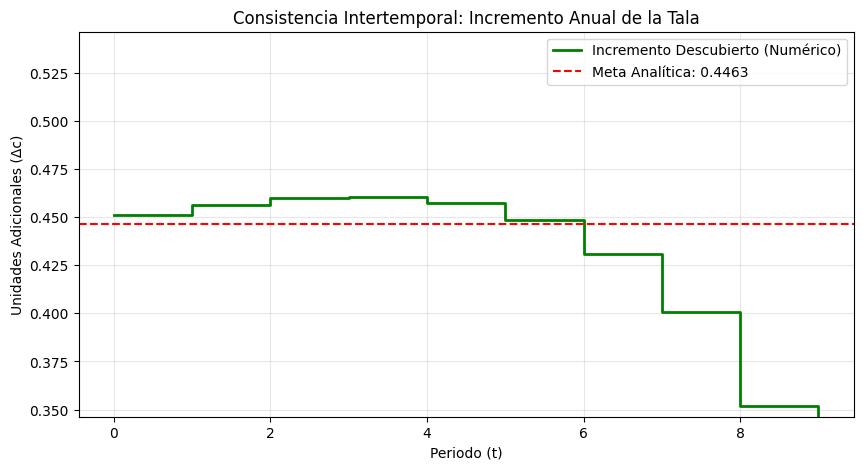

El algoritmo descubrió un incremento medio de: 0.4189


In [7]:
# --- 6. CÁLCULO DE LOS INCREMENTOS REALES Y VISUALIZACIÓN ---
# Calculamos la diferencia entre la extracción de hoy y la de mañana (ct+1 - ct)
incrementos_reales = [c_hist[i+1] - c_hist[i] for i in range(len(c_hist)-1)]

# Verificamos el valor teórico
# el incremento debe ser ln(alpha) / gamma
valor_teorico = np.log(alpha) / gamma

# generamos la gráfica
plt.figure(figsize=(10, 5))

# Graficamos los incrementos descubiertos por el código
plt.step(range(len(incrementos_reales)), incrementos_reales, where='post',
         color='green', linewidth=2, label='Incremento Descubierto (Numérico)')

# Línea horizontal para el valor teórico esperado
plt.axhline(y=valor_teorico, color='red', linestyle='--',
            label=f'Meta Analítica: {valor_teorico:.4f}')

plt.title('Consistencia Intertemporal: Incremento Anual de la Tala')
plt.xlabel('Periodo (t)')
plt.ylabel('Unidades Adicionales (Δc)')
plt.ylim(valor_teorico - 0.1, valor_teorico + 0.1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"El algoritmo descubrió un incremento medio de: {np.mean(incrementos_reales):.4f}")
